In [111]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Minimum Variance Portfolio Backtest.

In [112]:
import pandas as pd
from qamsi.config.trading_config import TradingConfig
from qamsi.runner import Runner
from qamsi.strategies.estimated.min_var import MinVariance
from qamsi.cov_estimators.cov_estimators import CovEstimators
from qamsi.features.preprocessor import Preprocessor
from run import Dataset

In [113]:
REBAL_FREQ = "ME"
DATASET = Dataset.SPX_US
ESTIMATION_WINDOW = 365 * 1

In [114]:
experiment_config = DATASET.value()

stocks = tuple(
    pd.read_csv(experiment_config.PATH_OUTPUT / experiment_config.STOCKS_LIST_FILENAME)
    .iloc[:, 0]
    .astype(str)
    .tolist(),
)
experiment_config.ASSET_UNIVERSE = stocks  # type: ignore  # noqa: PGH003

experiment_config.MIN_ROLLING_PERIODS = ESTIMATION_WINDOW + 1
experiment_config.N_LOOKBEHIND_PERIODS = None
experiment_config.REBALANCE_FREQ = REBAL_FREQ

factors = pd.read_csv(experiment_config.PATH_OUTPUT / "factors.csv")
factors["date"] = pd.to_datetime(factors["date"])
factors = factors.set_index("date")
factor_names = tuple(factors.columns.astype(str).tolist())
experiment_config.FACTORS = factor_names

prices = [stock + "_Price" for stock in list(stocks)]
preprocessor = Preprocessor(
    exclude_names=[
        *list(stocks),
        experiment_config.RF_NAME,
        *experiment_config.HEDGING_ASSETS,
        *factor_names,
        *prices,
    ],
)

trading_config = TradingConfig(
    broker_fee=0.05 / 100,
    bid_ask_spread=0.03 / 100,
    total_exposure=1,
    max_exposure=1,
    min_exposure=0,
    trading_lag_days=1,
)

runner = Runner(
    experiment_config=experiment_config,
    trading_config=trading_config,
    verbose=True,
)

Backtest on 2004-03-19 00:00:00 to 2023-12-29 00:00:00


In [115]:
ESTIMATOR = CovEstimators.UNCERT_ENSEMBLE.value(shrinkage_type="linear")

strategy = MinVariance(
    cov_estimator=ESTIMATOR,
    trading_config=trading_config,
    window_size=ESTIMATION_WINDOW,
)

strategy_name = ESTIMATOR.__class__.__name__

result = runner(
    feature_processor=preprocessor,
    strategy=strategy,
    hedger=None,
)
result

Num Train Iterations: 221


Computing Weights: 100%|██████████| 221/221 [00:44<00:00,  4.94it/s]


StrategyStatistics:
* final_nav = 4.390784
* geom_avg_total_r = 0.105220
* geom_avg_xs_r = 0.070180
* std_xs_r = 0.137827
* min_xs_r = -0.090083
* max_xs_r = 0.088128
* skew = -0.180161
* kurtosis = 24.235385
* max_dd = -0.306177
* sharpe = 0.509185
* alpha_buy_hold = 0.007931
* tracking_error_buy_hold = 0.129269
* ir_buy_hold = 0.061352
* factor_loadings = {'low_risk': 0.42897587482369115, 'momentum': 0.00948923890100205, 'quality': -0.017077761970095657, 'size': 0.0905088494407388, 'value': -0.07986933044949383, 'spx': 0.6892148918263016}
* alpha_benchmark = 0.018107
* alpha_benchmark_pvalue = 0.275181
* tracking_error_benchmark = 0.065713
* ir_benchmark = 0.275540
* ttest_pval = 0.543669
* levene_pval = 0.000000
* timing_ability_coef = -0.025925
* timing_ability_pval = 0.051914

In [116]:
result.std_xs_r

np.float64(0.13782726878696855)

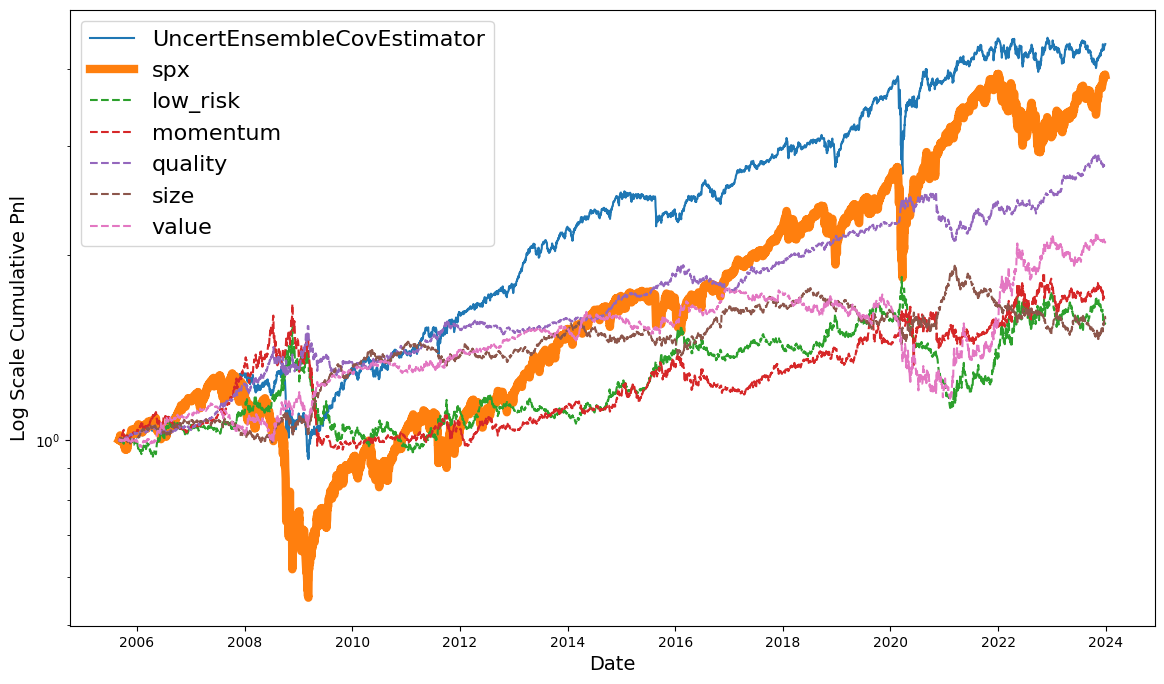

In [117]:
runner.plot_cumulative(
    strategy_name=strategy_name,
    include_factors=True,
)

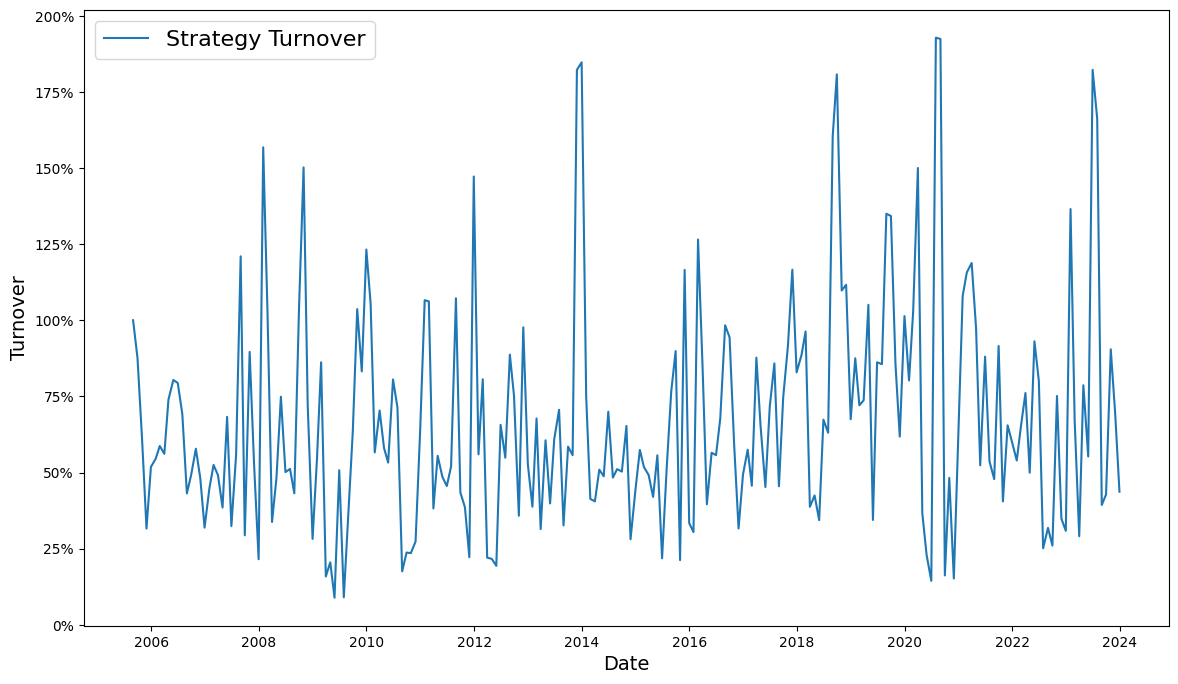

In [118]:
runner.plot_turnover()

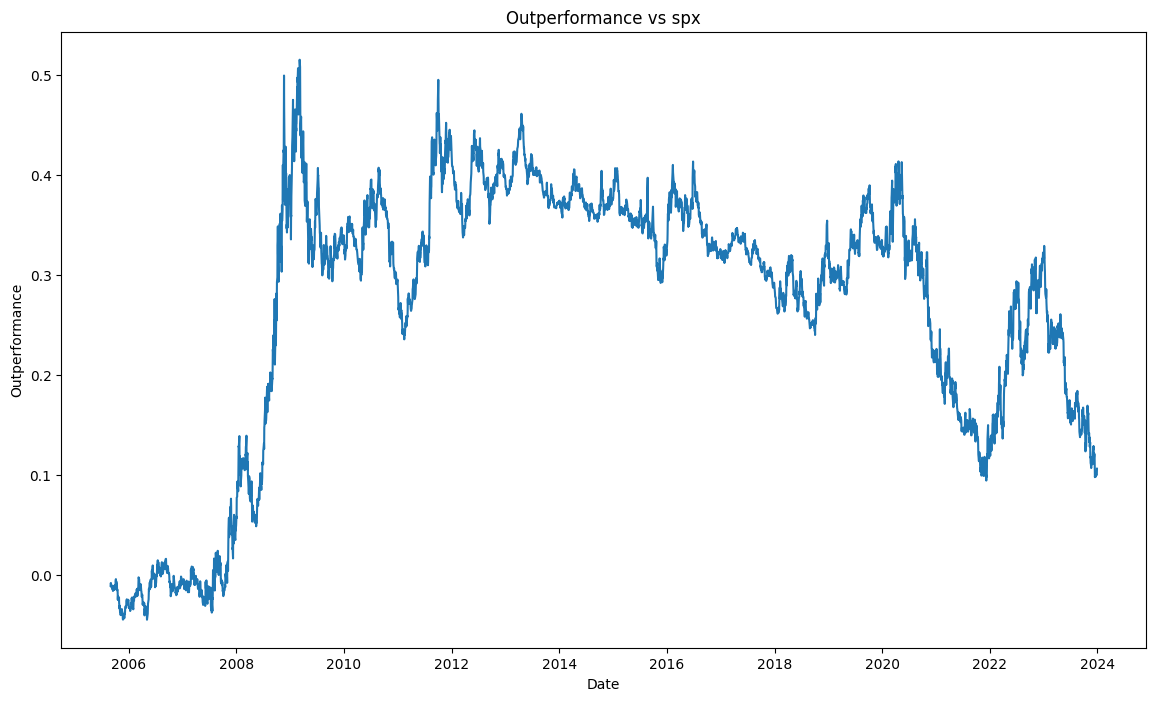

In [119]:
runner.plot_outperformance(mkt_only=True)

In [120]:
runner.save(DATASET.name + strategy_name + f"_rebal{REBAL_FREQ}")

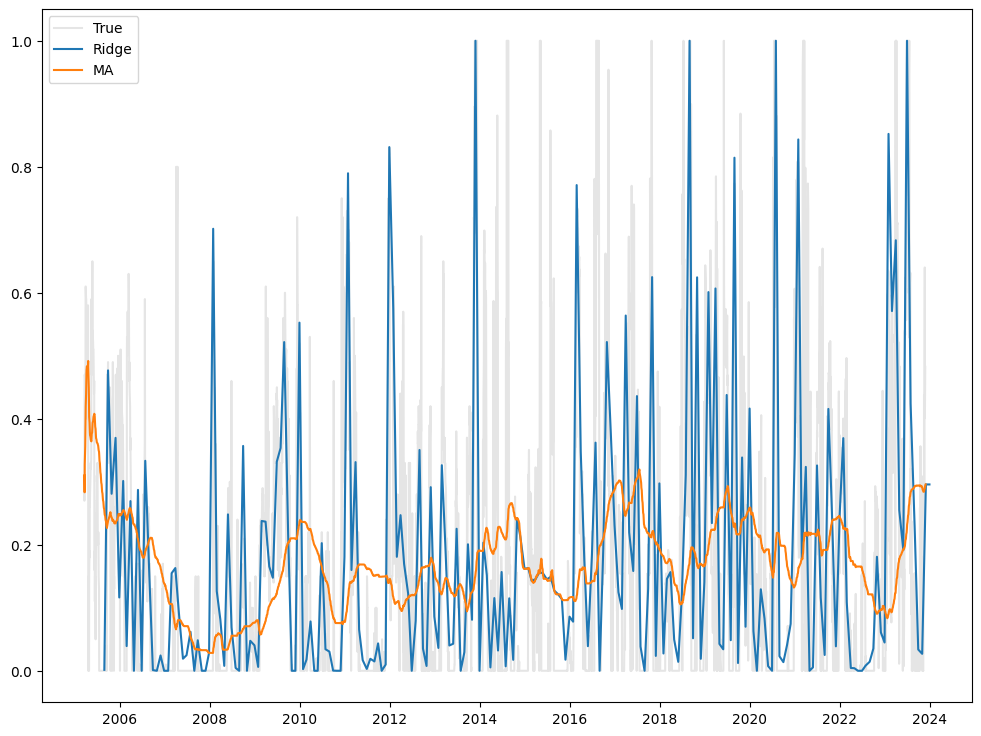

In [121]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))

ma = runner.features["l_shrinkage_mu"].shift(1)

plt.plot(
    runner.targets.index,
    runner.targets["l_shrinkage"],
    label="True",
    color="grey",
    alpha=0.2,
)
plt.plot(ESTIMATOR.predictions.index, ESTIMATOR.predictions.to_numpy(), label="Ridge")
plt.plot(ma.index, ma.to_numpy(), label="MA")

plt.legend()
plt.show()

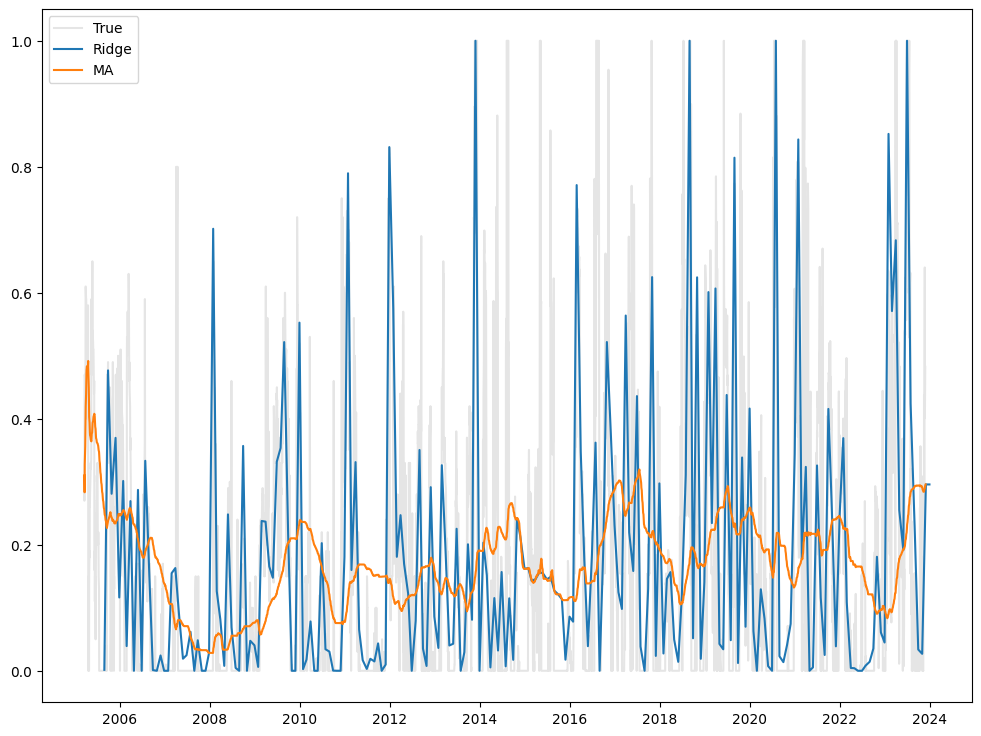

In [122]:
import numpy as np

plt.figure(figsize=(12, 9))

uncert = np.array(ESTIMATOR.uncert)
uncert = (uncert - np.mean(uncert)) / uncert.std()

plt.plot(
    runner.targets.index,
    runner.targets["l_shrinkage"],
    label="True",
    color="grey",
    alpha=0.2,
)
plt.plot(ESTIMATOR.predictions.index, ESTIMATOR.predictions.to_numpy(), label="Ridge")
plt.plot(ma.index, ma.to_numpy(), label="MA")

plt.legend()
plt.show()

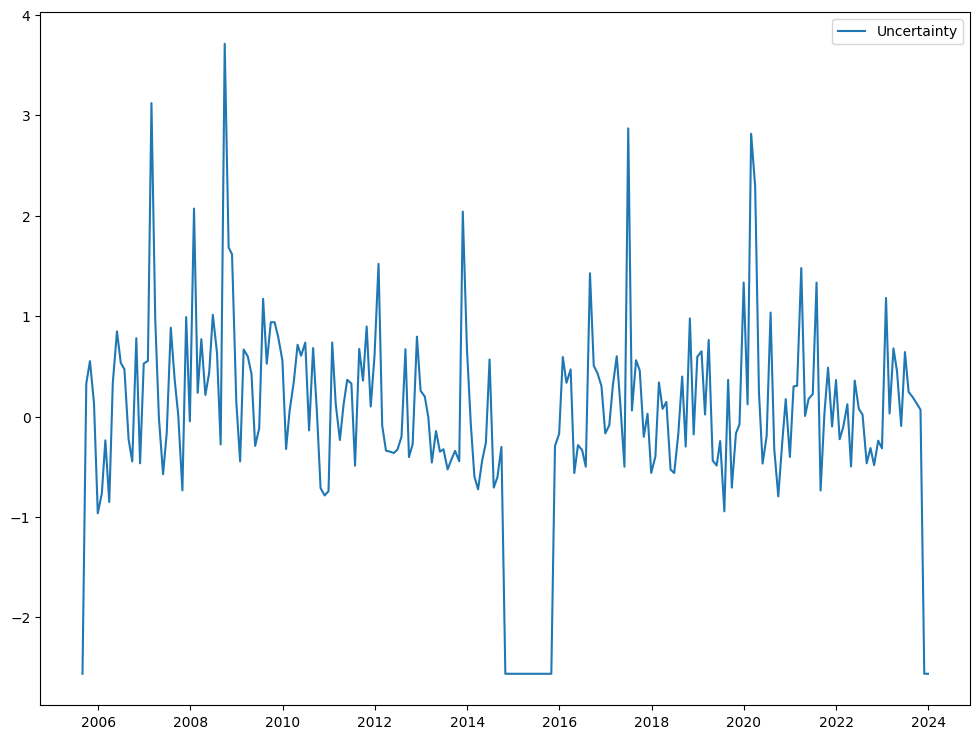

In [123]:
import numpy as np

plt.figure(figsize=(12, 9))

uncert = np.array(ESTIMATOR.uncert)
uncert = (uncert - np.mean(uncert)) / uncert.std()

plt.plot(ESTIMATOR.predictions.index, uncert, label="Uncertainty")

plt.legend()
plt.show()

In [124]:
import statsmodels.api as sm

X = ESTIMATOR.predictions.copy()
X["w"] = ESTIMATOR.uncert_w
y = runner.targets["l_shrinkage"].copy()
lr = sm.OLS(y.ffill().fillna(y.mean()).loc[X.index], X)
res = lr.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            l_shrinkage   R-squared (uncentered):                   0.930
Model:                            OLS   Adj. R-squared (uncentered):              0.930
Method:                 Least Squares   F-statistic:                              1463.
Date:                Thu, 12 Jun 2025   Prob (F-statistic):                   1.99e-127
Time:                        19:27:22   Log-Likelihood:                          264.42
No. Observations:                 221   AIC:                                     -524.8
Df Residuals:                     219   BIC:                                     -518.1
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
prediction     0.9754      0.023     42.708      0.000       0.930       1.020
w             -0.0195      0.006     -3.127      0.002      -0.032      -0.007
==============================================================================
Omnibus:                       47.626   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              290.701
Skew:                           0.626   Prob(JB):                     7.50e-64
Kurtosis:                       8.477   Cond. No.                         5.02
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [125]:
targ = ESTIMATOR.predictions.copy()
targ = y.ffill().fillna(y.mean()).loc[targ.index] - targ.to_numpy().flatten()

lr = sm.OLS(targ, ESTIMATOR.uncert_w)
res = lr.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            l_shrinkage   R-squared (uncentered):                   0.105
Model:                            OLS   Adj. R-squared (uncentered):              0.101
Method:                 Least Squares   F-statistic:                              25.93
Date:                Thu, 12 Jun 2025   Prob (F-statistic):                    7.59e-07
Time:                        19:27:22   Log-Likelihood:                          263.84
No. Observations:                 221   AIC:                                     -525.7
Df Residuals:                     220   BIC:                                     -522.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0239      0.005     -5.092      0.000      -0.033      -0.015
==============================================================================
Omnibus:                       42.092   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              271.668
Skew:                           0.483   Prob(JB):                     1.02e-59
Kurtosis:                       8.345   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [126]:
np.corrcoef(targ, ESTIMATOR.uncert)

array([[ 1.        , -0.31097933],
       [-0.31097933,  1.        ]])